# Data exploration

Lets take a look at the Melbourne pedestrian data and see what we think

In [1]:
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import Javascript
from IPython.display import HTML

import tqdm.notebook as tqdm

from ipyleaflet import Map, Marker,AwesomeIcon

from PedestrianDataImporter import getHourlyCounts
from MissingDataUtils import findMissingness, plotMissing
from DataFrameManipulations import countsLongToWideHourly
from Imputation import repairRepeatedMidnightStamps

In [2]:
# Also disable the scroll. I just don't like it
def disable_scroll():
    display(Javascript("""
        IPython.OutputArea.prototype._should_scroll = function(lines) {
            return false;
        }
    """))

disable_scroll()

<IPython.core.display.Javascript object>

In [3]:
df_counts,df_locations = getHourlyCounts['Melbourne']()
df_counts = repairRepeatedMidnightStamps(df_counts)
df_wide   = countsLongToWideHourly(df_counts)

Loading Melbourne_stored.pkl


Closer inspection of the dataframes reveals that
* Not all the locations in the counts dataframe have locations in the locations dataframe.
* Not all the location in the locations dataframe have a record in the counts dataframe

In [26]:
l1 = df_counts['LocationName']
l2 = df_locations['Location_Desc']

print(f"{l1.nunique()} unique locations in count")
print(f"{l2.shape[0]} rows in location" )
print(f"{l2.nunique()} in counts")
print()

inBoth = list( set(l1).intersection(l2) )
justL1 = list( set(l1) - set(l2))
justL2 = list( set(l2) - set(l1))

print(f"{len(inBoth)} in both sets")
print(f"{len(justL1)} just in count data")
print(f"{len(justL2)} just in location data")

94 unique locations in count
113 rows in location
110 in counts

66 in both sets
28 just in count data
44 just in location data


What are the reasons for the duplicated location data?
* Birrarund Marr seems to have two sensors, one for pedestrians and one for bicycles
* Birrarung Marr East - Batman Ave Bridge Entry has two sensors in different directions.
* Harbour Esplanade just seems to be repeated twice.

In [29]:
duplicate_rows = df_locations[df_locations['Location_Desc'].duplicated(keep=False)]
duplicate_rows = duplicate_rows.sort_values('Location_Desc')
duplicate_rows

,Location_ID,Location_Desc,Sensor_Name,Installation_Date,Note,Location_Type,Status,Direction_1,Direction_2,Latitude,Longitude,Location
36,122,Birrarung Marr,FedCycle_T,2022-08-23,NaN,Outdoor,A,East,West,-37.818629,144.971694,"-37.81862929, 144.97169395"
42,7,Birrarung Marr,FedPed_T,2014-12-17,NaN,Outdoor,A,East,West,-37.818629,144.971694,"-37.81862929, 144.97169395"
37,124,Birrarung Marr East - Batman Ave Bridge Entry,BirBridge_T,2023-06-02,NaN,Outdoor,A,North,South,-37.817574,144.973299,"-37.81757416, 144.97329934"
81,123,Birrarung Marr East - Batman Ave Bridge Entry,BirBridge_T,2023-06-02,<Null>,Outdoor,A,East,West,-37.817537,144.973297,"-37.81753741, 144.97329734"
33,111,Harbour Esplanade,HarbBlix_T,2021-03-25,NaN,Outdoor Blix,A,NaN,NaN,-37.814426,144.944366,"-37.81442577, 144.94436558"
111,120,Harbour Esplanade,HarbBlix_T,2021-03-25,NaN,Outdoor Blix,A,NaN,NaN,-37.814426,144.944366,"-37.81442577, 144.94436558"


Only one site seems to seems to be counting bicycles

In [31]:
df_locations.loc[ df_locations['Sensor_Name'].str.contains('Cycle', case=False, na=False) ]

,Location_ID,Location_Desc,Sensor_Name,Installation_Date,Note,Location_Type,Status,Direction_1,Direction_2,Latitude,Longitude,Location
36,122,Birrarung Marr,FedCycle_T,2022-08-23,NaN,Outdoor,A,East,West,-37.818629,144.971694,"-37.81862929, 144.97169395"


## Site locations

First lets plot the sensor locations. Mouse of the icon to get the name of the sensor location

In [4]:
def showSensorLocations(df_locations,zoom=13):
    center = (df_locations['Latitude'].median(), df_locations['Longitude'].median())
    m = Map(center=center, zoom=zoom)
    icon=AwesomeIcon(name="map-pin", marker_color='red')
    for index,row in df_locations.iterrows():
        marker = Marker(location=(row['Latitude'],row['Longitude']),
                        icon=icon,
                        draggable=False,opacity=0.5,
                        title=f"{row['Location_Desc']} - {row['Location_ID']}"
                        )
        m.add_layer(marker)
    display(m)
    
showSensorLocations(df_locations)

Map(center=[-37.81441438, 144.96510921], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

## Inspecting missing data

  0%|          | 0/94 [00:00<?, ?it/s]

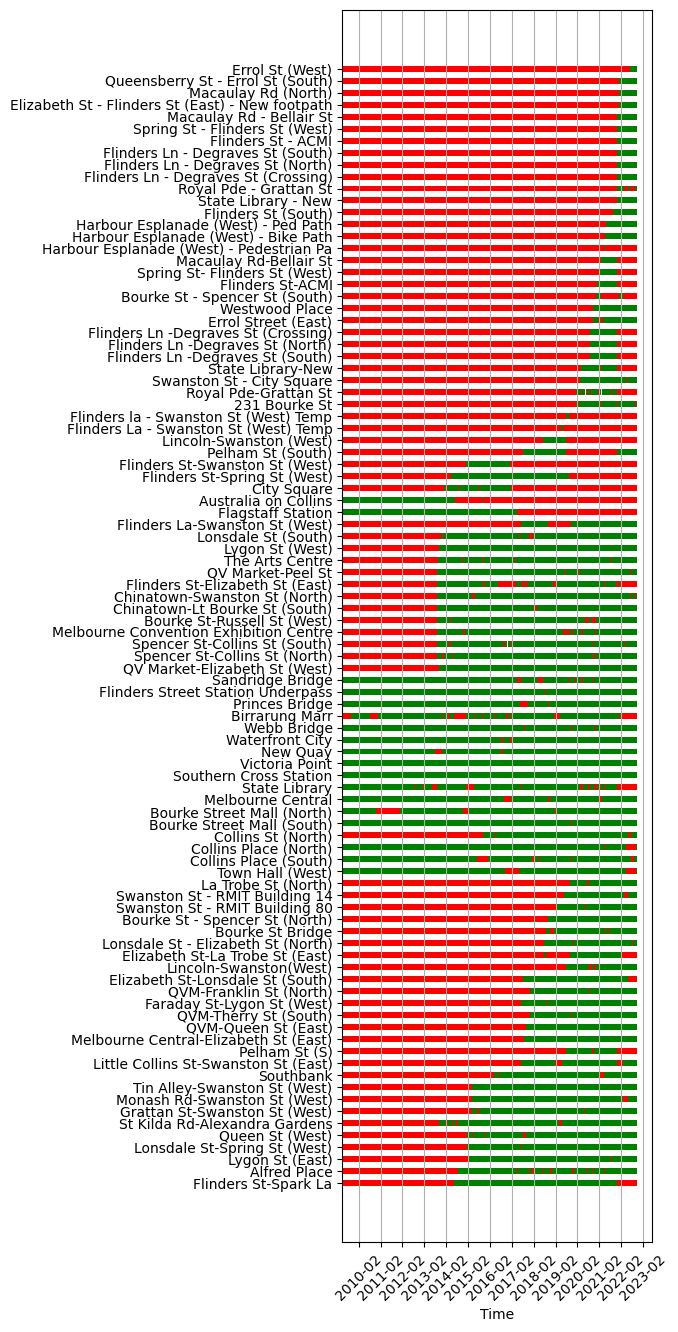

In [6]:
locations = df_counts['LocationName'].unique()
gaps_d = {location:findMissingness(df_wide,location) for location in tqdm.tqdm(locations)}
fig, ax = plt.subplots(figsize=(4,16))
plotMissing(gaps_d,ax)

## Inspection of the time series